# Solution for Ex 5 of the ibmqc 2021

This solution is from the point of view from someone who has just started to explore Quantum Computing, but is familiar with the physics behind it and has some experience with programming and optimization problems.

So I did not create this solution entirely by myself, but altered the tutorial solution from the H-H molecule which was provided.

The goal was to create an ansatz with the lowest possible number of CNOT gates.



In [7]:
from qiskit_nature.drivers import PySCFDriver

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)

qmolecule = driver.run()

There were many hints on how to reduce the problem to a manageable, in particular reducing the number of qubits, hence resulting in smaller circuits with fewer operations. A first hint was to freeze the core, since Li has the configuration of 2 electrons in the 1s orbital and 1 in the 2s orbital (which forms bonds with other atoms). The electrons in orbitals nearer the core can therefore be frozen.

Li : 1s, 2s, and px, py, pz orbitals  --> 6  orbitals

H  : 1s                               --> 1 orbital


In [8]:
from qiskit_nature.transformers  import FreezeCoreTransformer

trafo = FreezeCoreTransformer(freeze_core=True)
q_molecule_reduced = trafo.transform(qmolecule)

There are 5 properties to consider to better understand the task. Note that there was already a transformation. Before this transformation the properties would have been (in this order: 4, 6, 12, 12, 1.0259348796432726)

In [9]:
n_el = q_molecule_reduced.num_alpha + q_molecule_reduced.num_beta
print("Number of electrons in the system: ", n_el)

n_mo = q_molecule_reduced.num_molecular_orbitals
print("Number of molecular orbitals: ", n_mo)

n_so = 2 * q_molecule_reduced.num_molecular_orbitals
print("Number of spin orbitals: ", n_so)

n_q = 2 * q_molecule_reduced.num_molecular_orbitals
print("Number of qubits one would need with Jordan-Wigner mapping:", n_q)

e_nn = q_molecule_reduced.nuclear_repulsion_energy
print("Nuclear repulsion energy", e_nn)

Number of electrons in the system:  2
Number of molecular orbitals:  5
Number of spin orbitals:  10
Number of qubits one would need with Jordan-Wigner mapping: 10
Nuclear repulsion energy 1.0259348796432726


#### Electronic structure problem

One can then create an `ElectronicStructureProblem` that can produce the list of fermionic operators before mapping them to qubits (Pauli strings). 

In the following cell on could also use a quantum molecule transformer to remove orbitals which would not contribute to the ground state - for example px and py in this problem. Why they correspond to orbitals 3 and 4 I'm not really sure, maybe one has to look through the documentation a bit better than I did, but since there were only very limited combinations I tried them at random and kept an eye on the ground state energy.

In [10]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

problem= ElectronicStructureProblem(driver, q_molecule_transformers=[FreezeCoreTransformer(freeze_core=True, 
                                                                                           remove_orbitals=[3,4])])

second_q_ops = problem.second_q_ops() 

# Hamiltonian
main_op = second_q_ops[0]

###  QubitConverter

Allows to define the mapping that you will use in the simulation. For the LiH problem the Parity mapper is chosen, because it allows the "TwoQubitReduction" setting which will further simplify the problem.

If I understand the paper correctly - referenced as [Bravyi *et al*, 2017](https://arxiv.org/abs/1701.08213v1)- symmetries from particle number operators such eq 52 of the paper are used to reduce the number of qubits. The only challenging thing was to understand what [1] is meaning if you pass this as the z2symmetry-reduction parameter. 

In [11]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper = ParityMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1])

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

####  Initial state
One has to chose an initial state for the system which is reduced to 4 qubits from 12 at the beginning. The initialisation may be chosen by you or you stick to the one proposed by the Hartree-Fock function (i.e. $|\Psi_{HF} \rangle = |1100 \rangle$). For the Exercise it is recommended to stick to stick to the function!

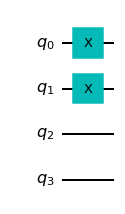

In [12]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
init_state.draw('mpl')

5. Ansatz

Playing with the Ansatz was really fun. I found the TwoLocal Ansatz very interesting to gain some knowlegde and insight on how to compose an ansatz for the problem. Later on I tried to create my own Ansatz and converged to an Ansatz quite similiar to a TwoLocal one. 

It's obvious you have to entangle the qubits somehow with CNOTs. But to give the optimization algorithm a chance to find a minimum, you have to make sure to change the states of the qubits before and afterwards independently of the other ones.

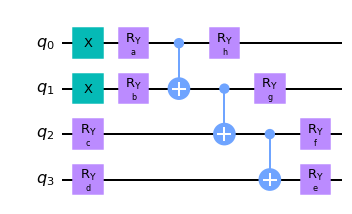

In [14]:
# Choose the ansatz
ansatz_type = "Custom"

# Parameters for q-UCC ansatz
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)

num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry']
    # Entangling gates
    entanglement_blocks = ['cx']
    # How the qubits are entangled 
    entanglement = 'linear'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = False
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    from qiskit.circuit.random import random_circuit
    # Define the variational parameter
    param_names_theta = ['a', 'b', 'c', 'd']
    thetas = [Parameter(param_names_theta[i]) for i in range(len(param_names_theta))]
    
    param_names_eta = ['e', 'f', 'g', 'h']
    etas = [Parameter(param_names_eta[i]) for i in range(len(param_names_eta))]
    
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a CNOT ladder
    for i in range(n):
        qc.ry(thetas[i], i)
    for i in range(n-1):
        qc.cx(i, i+1)
    for i in range(n):
        qc.ry(etas[n-i-1], i)
    
    # Visual separator

    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

ansatz.draw('mpl')

### Backend
This is where you specify the simulator or device where you want to run your algorithm.
We will focus on the `statevector_simulator` in this challenge.

In [15]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

### Optimizer

The optimizer guides the evolution of the parameters of the ansatz so it is very important to investigate the energy convergence as it would define the number of measurements that have to be performed on the QPU.
A clever choice might reduce drastically the number of needed energy evaluations.

Some of the optimizer seem to not reach the minimum. So the choice of the optimizer and the parameters is important.
I did not get to the minimum with the other optimizers than SLSQP.

I found a very nice and short explanation of how the optimizer works on stackoverflow:

The algorithm described by Dieter Kraft is a quasi-Newton method (using BFGS) applied to a lagrange function consisting of loss function and equality- and inequality-constraints. Because at each iteration some of the inequality constraints are active, some not, the inactive inequalities are omitted for the next iteration. An equality constrained problem is solved at each step using the active subset of constraints in the lagrange function.

https://stackoverflow.com/questions/59808494/how-does-the-slsqp-optimization-algorithm-work


In [16]:
from qiskit.algorithms.optimizers import SLSQP

optimizer = SLSQP(maxiter=4000)   

### Exact eigensolver

In the exercise we got the following exact diagonalizer function to compare the results.

In [17]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)

Exact electronic energy -1.0887060157347395


###  VQE and initial parameters for the ansatz
Now we can import the VQE class and run the algorithm. This code was also provided. Everything I have done so far is plugged in.

In [18]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 382,
    'eigenstate': array([ 1.44321615e-03-1.59287567e-19j, -4.96356230e-03+1.09953024e-18j,
        2.65616181e-02-5.76918357e-18j, -9.91390908e-01+2.20136437e-16j,
       -5.41564471e-02+5.38915649e-18j, -2.74469803e-04+1.69220065e-19j,
        9.17458284e-04-1.67318657e-19j, -2.41082746e-02+5.35265300e-18j,
       -2.75857713e-03+2.74533103e-19j, -6.17015014e-06+6.88485404e-21j,
        4.95895920e-06+5.49186628e-22j,  3.30740666e-04-7.34679532e-20j,
        1.13528105e-01-1.12980809e-17j,  3.22376435e-04-2.98545398e-19j,
       -5.70160578e-04+5.68985771e-20j,  4.83002677e-05-9.58780506e-21j]),
    'eigenvalue': -1.0863669627947063,
    'optimal_parameters': {   Parameter(f): 3.190179597722609,
                              Parameter(d): -2.6961315742534335,
                              Parameter(e): 0.44479188162835886,
                              Parameter(a): 0.25224802080112607,
                             

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,SLSQP,QuantumCircuit,4,8,NaN,NaN,NaN,NaN,2.339053,True,3
0,SLSQP,QuantumCircuit,4,8,None,None,None,None,2.339053,True,3


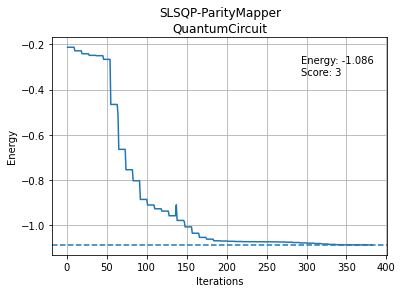

In [19]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

In [20]:
# Check your answer using following code
from qc_grader import grade_ex5
freeze_core = True # change to True if you freezed core electrons
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.



Thank you very much for this awesome challenge. Without the outline, explanations, examples and hints I would have never been able to solve this in a reasonable time.

I will definitely save this Notebook along with the other exercises as a bluprint for the future.